# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip
! unzip -qq devkit_object.zip

--2019-05-27 18:40:30--  https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.88
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63778 (62K) [application/zip]
Saving to: ‘devkit_object.zip’

devkit_object.zip   100%[===================>]  62.28K  --.-KB/s    in 0.03s   

2019-05-27 18:40:35 (2.03 MB/s) - ‘devkit_object.zip’ saved [63778/63778]



In [0]:
# ! pip install pykitti
# ! pip install open3d-python

import numpy as np
import pandas as pd

from open3d import draw_geometries, PointCloud, Vector3dVector
import pykitti
import numpy as np
import tqdm

import kitti_transformation
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pykitti
import open3d
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
import cv2

%matplotlib inline

In [5]:
# ! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_calib.zip
# ! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_velodyne.zip
# ! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
  
# ! unzip raw_data_downloader.zip
# ! unzip data_object_calib.zip
# ! unzip data_object_velodyne.zip
# ! unzip data_object_image_2.zip
! unzip -qq data_object_label_2.zip

--2019-05-27 18:41:55--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.60
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5601213 (5.3M) [application/zip]
Saving to: ‘data_object_label_2.zip’

data_object_label_2 100%[===================>]   5.34M  --.-KB/s    in 0.1s    

2019-05-27 18:41:56 (36.7 MB/s) - ‘data_object_label_2.zip’ saved [5601213/5601213]



In [6]:
files=[
    '2011_09_26_calib.zip', 
'2011_09_26_drive_0001',
'2011_09_26_drive_0002',
'2011_09_26_drive_0005',
'2011_09_26_drive_0009',
'2011_09_26_drive_0011',
'2011_09_26_drive_0013',
'2011_09_26_drive_0014',
'2011_09_26_drive_0015',
'2011_09_26_drive_0017',
'2011_09_26_drive_0018',
'2011_09_26_drive_0019',
'2011_09_26_drive_0020',
'2011_09_26_drive_0022',
'2011_09_26_drive_0023',
'2011_09_26_drive_0027',
'2011_09_26_drive_0028',
'2011_09_26_drive_0029',
'2011_09_26_drive_0032',
'2011_09_26_drive_0035',
'2011_09_26_drive_0036',
'2011_09_26_drive_0039',
'2011_09_26_drive_0046',
'2011_09_26_drive_0048',
'2011_09_26_drive_0051',
'2011_09_26_drive_0052',
'2011_09_26_drive_0056',
'2011_09_26_drive_0057',
'2011_09_26_drive_0059',
'2011_09_26_drive_0060',
'2011_09_26_drive_0061',
'2011_09_26_drive_0064',
'2011_09_26_drive_0070',
'2011_09_26_drive_0079',
'2011_09_26_drive_0084',
'2011_09_26_drive_0086',
'2011_09_26_drive_0087',
'2011_09_26_drive_0091',
'2011_09_26_drive_0093',
'2011_09_26_drive_0095',
'2011_09_26_drive_0096',
'2011_09_26_drive_0101',
'2011_09_26_drive_0104',
'2011_09_26_drive_0106',
'2011_09_26_drive_0113',
'2011_09_26_drive_0117',
'2011_09_26_drive_0119']

for i in files:
  if i[-3:] != 'zip':
    sn = i + '_sync.zip'
    fn = i + '/' + i + '_sync.zip'
  else:
    sn = i
    fn = i
  
  ! wget 'https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/'{fn}
  ! unzip -qq -o {sn}
  ! rm {sn}

--2019-05-27 18:42:05--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.131
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2019-05-27 18:42:05 (126 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]

--2019-05-27 18:42:10--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.68
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458643963 (437M) [application/zip]
Sa

In [0]:
MAPPING_PATH = 'mapping'
RAW_DOWNLOADER_PATH = ''
LABELS_PATH = 'training/label_2/'

RAW_DATA_PATH=''

In [10]:
sequences = kitti_transformation.sequence_dict_creation(delta = 1, threshold = 10,MAPPING_PATH=MAPPING_PATH,LABELS_PATH=LABELS_PATH)
train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(sequences.keys())),
                                                         np.arange(0, len(sequences.keys())), test_size=0.2,
                                                         random_state=115)
train_dataset = kitti_transformation.KittiDatasetFull(1, train_indexes,sequences, RAW_DATA_PATH=RAW_DATA_PATH)

train_indexes

Data consists of  141  unfiltered sequences
Final number of sequences  77


array([26, 34, 60,  1, 67,  4, 68, 30,  3, 53, 47, 66, 61, 74,  9, 76, 45,
       50, 48, 24, 42, 10, 38, 28, 40,  8, 70, 11, 58, 52, 51, 59, 71, 19,
       13, 75, 17,  5, 20, 63, 22,  2, 43, 57, 29, 36, 69, 49, 72,  7, 65,
       12, 46, 62, 41, 31, 14, 16,  6, 32, 18])

In [11]:
train = []
train_labels = []
train_coords = []

plt.ioff()

for transformed_clouds, transformed_labels in tqdm.tqdm(train_dataset, total = len(train_dataset)):
  
  if transformed_clouds is None:
    continue
  
  for img, img_label in zip(transformed_clouds, transformed_labels):
  
    img = np.matrix(img.numpy())
    x_transform = MinMaxScaler().fit(img[:, 0].reshape(-1, 1))
    y_transform = MinMaxScaler().fit(img[:, 1].reshape(-1, 1))

    img[:, 0] = np.round(x_transform.transform(img[:, 0].reshape(-1, 1)) * 298)
    img[:, 1] = np.round(y_transform.transform(img[:, 1].reshape(-1, 1)) * 298)
    img[:, 2] = MinMaxScaler().fit_transform(img[:, 2].reshape(-1, 1)) * 255
    new_img = np.zeros((300, 300))

    for row in img:
      new_img[int(row[0, 0]), int(row[0, 1])] = row[0, 2]

#     plt.imshow(new_img, interpolation='nearest')
    train.append(new_img)

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    loc_coords = []

    for m,info in enumerate(img_label):

        x,y,z = info[:3]
        boxes=info[3:-1].reshape(-1,2)
        loc_coords.append(info[3:-1])
        for i in range(len(boxes)):
            x0,y0=boxes[i-1]
            x1,y1=boxes[i]

            x0, x1 = x_transform.transform(np.asarray([-1 * x0, -1 * x1]).reshape(-1, 1)) * 298
            y0, y1 = y_transform.transform(np.asarray([y0, y1]).reshape(-1, 1)) * 298


            ax.plot([y0,y1], [x0, x1], color = 'black')
            
    train_coords.append(loc_coords)


    plt.ylim(bottom = 0, top=300)
    plt.xlim(left = 0, right = 300)
    fig.savefig('temp.png', bbox_inches='tight')
#     plt.show()
    plt.close(fig)

    img_lab = cv2.imread('temp.png', 0)
    img_lab = cv2.resize(img_lab, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
    img_lab = 255 - img_lab

    train_labels.append(img_lab)

100%|██████████| 61/61 [27:49<00:00, 25.23s/it]


In [14]:
train_coords

array([list([tensor([ 10.3815, -21.5175,   8.7849, -18.7443,  10.2199, -17.9184,  11.8165,
        -20.6917], dtype=torch.float64), tensor([ 0.3000, -8.7671, -1.2383, -5.7575,  0.0942, -5.0772,  1.6324, -8.0868],
       dtype=torch.float64)]),
       list([tensor([  9.7414, -20.2286,   8.1406, -17.4578,   9.5746, -16.6297,  11.1755,
        -19.4005], dtype=torch.float64), tensor([ 0.2669, -8.6730, -1.3357, -5.6972, -0.0179, -4.9882,  1.5847, -7.9641],
       dtype=torch.float64)]),
       list([tensor([  9.1441, -19.0659,   7.5376, -16.2985,   8.9700, -15.4674,  10.5766,
        -18.2348], dtype=torch.float64), tensor([ 0.3207, -8.7049, -1.3470, -5.7649, -0.0451, -5.0269,  1.6226, -7.9669],
       dtype=torch.float64)]),
       ...,
       list([tensor([-17.9083,  20.2060, -20.0943,  23.1538, -18.7938,  24.1178, -16.6077,
         21.1700], dtype=torch.float64)]),
       list([tensor([-18.8824,  21.8194, -21.1008,  24.7430, -19.8111,  25.7213, -17.5927,
         22.7977], dtype=torch.

In [0]:
train = np.asarray(train)
train_labels = np.asarray(train_labels)
train_coords = np.asarray(train_coords)


In [0]:
np.savez_compressed('train_compr', img=train, mask=train_labels, mask_coords = train_coords)

In [0]:
# loaded = np.load('train_compr.npz')
# train = loaded['img']
# train_labels = loaded['mask']

In [16]:
train.shape, train_labels.shape, train_coords.shape

((1757, 300, 300), (1757, 300, 300), (1757,))

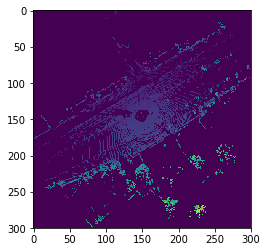

In [19]:
plt.imshow(train[0])

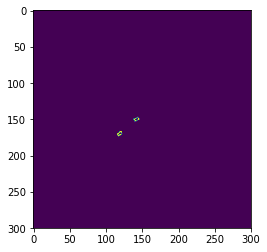

In [20]:
plt.imshow(train_labels[0])